In [1]:
import numpy as np

In [2]:
from all_in_one import tabular_simplex, dual_simplex

## Functions

In [3]:
# import numpy as np

# def is_dual_feasible(tableau):
#     # Check if all RHS values (excluding the objective row) are non-negative
#     return np.all(tableau[1:, -1] >= 0)

# def dual_simplex(tableau, num_original_vars, num_constraints, problem_type='max', verbose=True):
#     iteration = 0
#     while True:
#         iteration += 1
#         if verbose:
#             print_tableau(tableau, iteration, title="Dual Simplex Tableau")

#         if is_dual_feasible(tableau):
#             if verbose:
#                 print("Dual feasible solution found.")
#             optimal_solution, optimal_objective_value = extract_solution(tableau, num_original_vars, num_constraints, problem_type)
#             if verbose:
#                 print("Optimal solution:", np.round(optimal_solution, 3))
#                 print("Optimal objective value:", round(optimal_objective_value, 3))
#             return 'optimal', optimal_solution, optimal_objective_value

#         # Select leaving variable (row with the most negative RHS)
#         leaving_row = select_leaving_variable_dual(tableau)
#         if leaving_row is None:
#             if verbose:
#                 print("Problem is infeasible (no leaving variable found).")
#             return 'infeasible', None, None

#         if verbose:
#             print(f"Leaving variable: Row {leaving_row}")

#         # Select entering variable (column with the minimum ratio)
#         entering_col = select_entering_variable_dual(tableau, leaving_row)
#         if entering_col is None:
#             if verbose:
#                 print("Problem is unbounded (no entering variable found).")
#             return 'unbounded', None, None

#         if verbose:
#             print(f"Entering variable: Column {entering_col}")

#         # Pivot
#         tableau = pivot(tableau, entering_col, leaving_row)

# def select_leaving_variable_dual(tableau):
#     rhs = tableau[1:, -1]
#     leaving_row = np.argmin(rhs) + 1  # +1 to offset the objective row
#     if rhs[leaving_row -1] >= 0: # Check if the most negative RHS is non-negative. If so, the solution is dual feasible.
#         return None
#     return leaving_row

# def select_entering_variable_dual(tableau, leaving_row):
#     ratios = []
#     for j in range(tableau.shape[1] - 1):
#         if tableau[leaving_row, j] < 0:
#             ratios.append(tableau[0, j] / abs(tableau[leaving_row, j]))
#         else:
#             ratios.append(np.inf)

#     if np.all(np.isinf(ratios)):  # Check if all ratios are infinite
#         return None
#     return np.argmin(ratios)

# def print_tableau(tableau, iteration=None):
#     if iteration is not None:
#         print(f"\n--- Iteration {iteration} ---")
#     print("Current Tableau:")
#     # Print a rounded copy of the tableau for easier reading
#     print(np.array_str(tableau, precision=3, suppress_small=True))
#     print("-" * 50)

# def tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type='max', verbose=True):
#     num_constraints, num_original_vars = constraint_matrix.shape

#     # Transform constraints if needed (e.g., converting '>=' constraints into '<=' constraints)
#     transformed_constraint_matrix, transformed_rhs_values = transform_constraints(constraint_matrix, rhs_values, senses)
#     tableau = setup_tableau(objective_coeffs, transformed_constraint_matrix, transformed_rhs_values, senses, problem_type)

#     if verbose:
#         print("\nInitial Tableau:")
#         print_tableau(tableau)
#         print("Explanation: We reach the solution when all coefficients in the objective row (first row) "
#               "are nonnegative. This means that no further improvements (increase in the choice variable) can "
#               "be achieved.")

#     # Initial infeasibility check (e.g., checking artificial variables)
#     status = check_infeasibility(tableau, num_original_vars, senses, num_constraints)
#     if status == 'infeasible':
#         if verbose:
#             print("The problem is infeasible at the initial tableau.")
#         return status, None, None

#     iteration = 0
#     while True:
#         iteration += 1

#         if verbose:
#             print_tableau(tableau, iteration)
        
#         # Check the optimality condition: If all coefficients in the objective row (except RHS) are nonnegative,
#         # then the current solution is optimal.
#         if np.all(tableau[0, :-1] >= 0):
#             if verbose:
#                 print("All coefficients in the objective row are now nonnegative.")
#                 print("Explanation: No further improvement is possible so the current solution is optimal.")
#             optimal_solution, optimal_objective_value = extract_solution(tableau, num_original_vars, num_constraints, problem_type)
#             if np.any(np.dot(transformed_constraint_matrix, optimal_solution) > transformed_rhs_values + 1e-6):
#                 if verbose:
#                     print("After checking, there is a violation in the constraints (infeasible basic variable)!")
#                 return 'infeasible', None, None
#             if verbose:
#                 print("Optimal solution reached!")
#                 print("Solution:", np.round(optimal_solution, 3))
#                 print("Objective value:", round(optimal_objective_value, 3))
#             return 'optimal', optimal_solution, optimal_objective_value

#         # Select entering variable: the variable with the most negative coefficient in the objective row.
#         entering_col_index = select_entering_variable(tableau)
#         if verbose:
#             print(f"Entering variable (most negative coefficient) is at column index: {entering_col_index}")
#             print(f"Coefficient value for entering variable: {tableau[0, entering_col_index]:.3f}")

#         # Calculate ratios to determine the leaving variable.
#         ratios = calculate_ratios(tableau, entering_col_index)
#         if verbose:
#             print("Calculating ratios for the pivot operation (RHS divided by pivot column coefficient):")
#             for idx, ratio in enumerate(ratios, start=1):
#                 if tableau[idx, entering_col_index] > 0:
#                     print(f"Row {idx}: RHS = {tableau[idx, -1]:.3f}, Coefficient = {tableau[idx, entering_col_index]:.3f}, Ratio = {tableau[idx, -1]:.3f} / {tableau[idx, entering_col_index]:.3f} = {ratio:.3f}")
#                 else:
#                     print(f"Row {idx}: Coefficient = {tableau[idx, entering_col_index]:.3f} (Not eligible for pivot, ratio = inf)")
                    
#         # Select leaving variable based on the minimum ratio rule.
#         leaving_row = select_leaving_variable(tableau, entering_col_index)
#         if leaving_row is None:
#             if verbose:
#                 print("No valid leaving variable found (all ratios are infinite). The problem is unbounded!")
#             return 'unbounded', None, None

#         if verbose:
#             print(f"Leaving variable (minimum ratio) is at row index: {leaving_row}")

#         # Perform the pivot operation.
#         tableau = pivot(tableau, entering_col_index, leaving_row)
#         if verbose:
#             print("After pivot operation, the tableau is updated as follows:")
#             print_tableau(tableau, iteration)

# def check_infeasibility(tableau, num_original_vars, senses, num_constraints):
#     # This check looks for artificial basic variables with nonzero values.
#     num_slack_vars = senses.count('<=')
#     artificial_vars_start = num_original_vars + num_slack_vars

#     for i in range(num_constraints):
#         basic_variable_cols = np.where(tableau[i+1, :num_original_vars + num_slack_vars + num_constraints] == 1)[0]
#         if len(basic_variable_cols) > 0:
#             basic_var = basic_variable_cols[0]
#             if basic_var >= artificial_vars_start and tableau[i+1, -1] != 0:
#                 return 'infeasible'
#     return None

# def select_entering_variable(tableau):
#     # Identify the most negative coefficient in the objective row (excluding the RHS).
#     return np.argmin(tableau[0, :-1])

# def calculate_ratios(tableau, entering_col_index):
#     ratios = []
#     # Compute ratios for each constraint (row 1 and onward)
#     for i in range(1, tableau.shape[0]):
#         if tableau[i, entering_col_index] > 0:
#             ratios.append(tableau[i, -1] / tableau[i, entering_col_index])
#         else:
#             ratios.append(np.inf)
#     return np.array(ratios)

# def select_leaving_variable(tableau, entering_col_index):
#     ratios = calculate_ratios(tableau, entering_col_index)
#     if np.all(ratios == np.inf):
#         return None
#     # Add one because the first row is the objective function
#     return np.argmin(ratios) + 1

# def pivot(tableau, entering_col_index, leaving_row):
#     print("The pivot element is the element at the intersection of the leaving row and the entering column.")
#     pivot_element = tableau[leaving_row, entering_col_index]
#     print(f"Pivot Element: Tableau[{leaving_row}, {entering_col_index}] = {pivot_element:.3f}")

#     print(f"Dividing row {leaving_row} by pivot element {pivot_element:.3f}")
#     tableau[leaving_row, :] = tableau[leaving_row, :] / pivot_element

#     print("Updated Tableau after dividing leaving row:")
#     print(np.array_str(tableau, precision=3, suppress_small=True))


#     for i in range(tableau.shape[0]):
#         if i != leaving_row:
#             factor = tableau[i, entering_col_index]
#             print(f"Eliminating variable in row {i} using factor {factor:.3f}")
#             tableau[i, :] -= factor * tableau[leaving_row, :]
#             print(f"Updated Tableau after eliminating row {i}:")
#             print(np.array_str(tableau, precision=3, suppress_small=True))

#     return tableau

# def setup_tableau(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type='max'):
#     num_constraints, num_original_vars = constraint_matrix.shape

#     if problem_type == 'min':
#         # Convert minimization to maximization by negating the objective coefficients.
#         objective_coeffs = -objective_coeffs

#     num_slack_vars = senses.count('<=')
#     num_surplus_vars = senses.count('>=')
#     num_artificial_vars = senses.count('=') + num_surplus_vars
#     num_total_vars = num_original_vars + num_slack_vars + num_artificial_vars

#     tableau = np.zeros((num_constraints + 1, num_total_vars + 1))
#     tableau[0, :num_original_vars] = -objective_coeffs  # Negate objective coefficients here

#     slack_surplus_index = num_original_vars
#     artificial_index = num_original_vars + num_slack_vars + num_surplus_vars
#     for i in range(num_constraints):
#         tableau[i + 1, :num_original_vars] = constraint_matrix[i, :]
#         tableau[i + 1, -1] = rhs_values[i]

#         if senses[i] == '<=':
#             tableau[i + 1, slack_surplus_index] = 1
#             slack_surplus_index += 1
#         elif senses[i] == '>=' or senses[i] == '=':
#             # For '>=' or '=' constraints, add an artificial variable to help find a basic feasible solution.
#             tableau[i + 1, artificial_index - num_surplus_vars] = 1
#             artificial_index += 1
#             if senses[i] == '>=':
#                 # Also add a surplus variable (which will have a negative sign)
#                 tableau[i + 1, slack_surplus_index] = -1
#                 slack_surplus_index += 1
#     return tableau

# def extract_solution(tableau, num_original_vars, num_constraints, problem_type='max'):
#     optimal_solution = np.zeros(num_original_vars)
#     # Look through each original variable column to see if it's a basic variable.
#     for i in range(num_original_vars):
#         column = tableau[:, i]
#         if np.sum(np.abs(column)) == 1 and np.count_nonzero(column == 1) == 1:
#             basic_variable_row = np.where(column == 1)[0][0]
#             optimal_solution[i] = tableau[basic_variable_row, -1]

#     optimal_objective_value = tableau[0, -1]
#     if problem_type == 'min':
#         optimal_objective_value = -optimal_objective_value
#     return optimal_solution, optimal_objective_value

# def transform_constraints(constraint_matrix, rhs_values, senses):
#     transformed_constraint_matrix = constraint_matrix.copy()
#     transformed_rhs_values = rhs_values.copy()
#     for i, sense in enumerate(senses):
#         if sense == '>=':
#             # Multiply the constraint by -1 to convert '>=' into '<='.
#             transformed_constraint_matrix[i, :] = -constraint_matrix[i, :]
#             transformed_rhs_values[i] = -rhs_values[i]
#     return transformed_constraint_matrix, transformed_rhs_values


## Test question

In [4]:
# Example usage:
if __name__ == "__main__":
    # Define a sample linear programming problem.
    # Example: Maximize Z = 3x + 5y
    # Subject to:
    #   2x + y <= 10
    #   x + 3y <= 12
    #   x, y >= 0
    objective_coeffs = np.array([3, 5])
    constraint_matrix = np.array([[2, 1],
                                  [1, 3]])
    rhs_values = np.array([10, 12])
    senses = ['<=', '<=']  # Both constraints are of the form <=

    status, solution, objective_value = tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type='max', verbose=True)
    print("\nFinal Result:")
    print("Status:", status)
    if solution is not None:
        print("Solution:", np.round(solution, 3))
    if objective_value is not None:
        print("Objective Value:", round(objective_value, 3))


Initial Tableau:
Current Tableau:
[[-3. -5.  0.  0.  0.]
 [ 2.  1.  1.  0. 10.]
 [ 1.  3.  0.  1. 12.]]
--------------------------------------------------
Explanation: We reach the solution when all coefficients in the objective row (first row) are nonnegative. This means that no further improvements can be achieved.

--- Iteration 1 ---
Current Tableau:
[[-3. -5.  0.  0.  0.]
 [ 2.  1.  1.  0. 10.]
 [ 1.  3.  0.  1. 12.]]
--------------------------------------------------
Entering variable (most negative coefficient) is at column index: 1
Coefficient value for entering variable: -5.000
Calculating ratios for the pivot operation (RHS divided by pivot column coefficient):
Row 1: RHS = 10.000, Coefficient = 1.000, Ratio = 10.000 / 1.000 = 10.000
Row 2: RHS = 12.000, Coefficient = 3.000, Ratio = 12.000 / 3.000 = 4.000
Leaving variable (minimum ratio) is at row index: 2
The pivot element is the element at the intersection of the leaving row and the entering column.
Pivot Element: Tableau[

In [5]:
objective_coeffs = np.array([5, 4])
constraint_matrix = np.array([[3, 5],
                                [4, 1]])
rhs_values = np.array([78, 36])
senses = ['<=', '<=']  # Both constraints are of the form <=

status, solution, objective_value = tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type='max', verbose=True)
print("\nFinal Result:")
print("Status:", status)
if solution is not None:
    print("Solution:", np.round(solution, 3))
if objective_value is not None:
    print("Objective Value:", round(objective_value, 3))


Initial Tableau:
Current Tableau:
[[-5. -4.  0.  0.  0.]
 [ 3.  5.  1.  0. 78.]
 [ 4.  1.  0.  1. 36.]]
--------------------------------------------------
Explanation: We reach the solution when all coefficients in the objective row (first row) are nonnegative. This means that no further improvements can be achieved.

--- Iteration 1 ---
Current Tableau:
[[-5. -4.  0.  0.  0.]
 [ 3.  5.  1.  0. 78.]
 [ 4.  1.  0.  1. 36.]]
--------------------------------------------------
Entering variable (most negative coefficient) is at column index: 0
Coefficient value for entering variable: -5.000
Calculating ratios for the pivot operation (RHS divided by pivot column coefficient):
Row 1: RHS = 78.000, Coefficient = 3.000, Ratio = 78.000 / 3.000 = 26.000
Row 2: RHS = 36.000, Coefficient = 4.000, Ratio = 36.000 / 4.000 = 9.000
Leaving variable (minimum ratio) is at row index: 2
The pivot element is the element at the intersection of the leaving row and the entering column.
Pivot Element: Tableau[

## Example questions

In [6]:
from webapp.example_problems import example_problems

problem_name, problem_data = list(example_problems.items())[0]
print(f"\n{problem_name}:")

objective_coeffs = np.array(problem_data["objective_coeffs"])
constraint_matrix = np.array(problem_data["constraint_matrix"])
rhs_values = np.array(problem_data["rhs_values"])
senses = problem_data["senses"]
problem_type = problem_data["problem_type"]

status, solution, objective_value = tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type)

if solution is not None:
    print("Solution:", solution)
if objective_value is not None:
    print("Objective Value:", objective_value)


Example 1: Maximization:

Initial Tableau:
Current Tableau:
[[-3. -5.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  4.]
 [ 0.  2.  0.  1.  0. 12.]
 [ 3.  2.  0.  0.  1. 18.]]
--------------------------------------------------
Explanation: We reach the solution when all coefficients in the objective row (first row) are nonnegative. This means that no further improvements can be achieved.

--- Iteration 1 ---
Current Tableau:
[[-3. -5.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  4.]
 [ 0.  2.  0.  1.  0. 12.]
 [ 3.  2.  0.  0.  1. 18.]]
--------------------------------------------------
Entering variable (most negative coefficient) is at column index: 1
Coefficient value for entering variable: -5.000
Calculating ratios for the pivot operation (RHS divided by pivot column coefficient):
Row 1: Coefficient = 0.000 (Not eligible for pivot, ratio = inf)
Row 2: RHS = 12.000, Coefficient = 2.000, Ratio = 12.000 / 2.000 = 6.000
Row 3: RHS = 18.000, Coefficient = 2.000, Ratio = 18.000 / 2.000 = 9.000
Leav

In [7]:
from webapp.example_problems import example_problems

problem_name, problem_data = list(example_problems.items())[1]
print(f"\n{problem_name}:")

objective_coeffs = np.array(problem_data["objective_coeffs"])
constraint_matrix = np.array(problem_data["constraint_matrix"])
rhs_values = np.array(problem_data["rhs_values"])
senses = problem_data["senses"]
problem_type = problem_data["problem_type"]

status, solution, objective_value = tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type)

if solution is not None:
    print("Solution:", solution)
if objective_value is not None:
    print("Objective Value:", objective_value)


Example 2: Minimization:

Initial Tableau:
Current Tableau:
[[  2.   3.   0.   0.   0.]
 [ -1.  -1.  -1.   0. -10.]
 [  2.   1.   0.   1.  16.]]
--------------------------------------------------
Explanation: We reach the solution when all coefficients in the objective row (first row) are nonnegative. This means that no further improvements can be achieved.
Converting minimization problem to its dual formulation for solution.
Constructed dual problem from primal minimization problem.

Initial Tableau:
Current Tableau:
[[ 10. -16.   0.   0.   0.]
 [ -1.   2.   1.   0.   2.]
 [ -1.   1.   0.   1.   3.]]
--------------------------------------------------
Explanation: We reach the solution when all coefficients in the objective row (first row) are nonnegative. This means that no further improvements can be achieved.

--- Iteration 1 ---
Current Tableau:
[[ 10. -16.   0.   0.   0.]
 [ -1.   2.   1.   0.   2.]
 [ -1.   1.   0.   1.   3.]]
--------------------------------------------------
E

In [8]:
problem_name, problem_data = list(example_problems.items())[7]
print(f"\n{problem_name}:")

objective_coeffs = np.array(problem_data["objective_coeffs"])
constraint_matrix = np.array(problem_data["constraint_matrix"])
rhs_values = np.array(problem_data["rhs_values"])
senses = problem_data["senses"]
problem_type = problem_data["problem_type"]

status, solution, objective_value = tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type, verbose=False)
    
if solution is not None:
    print("Solution:", solution)
if objective_value is not None:
    print("Objective Value:", objective_value)


Example 8: Minimization with Three Variables:
Solution: [0. 0. 0.]
Objective Value: 0.0


In [9]:
from webapp.example_problems import example_problems

problem_name, problem_data = list(example_problems.items())[6]
print(f"\n{problem_name}:")

objective_coeffs = np.array(problem_data["objective_coeffs"])
constraint_matrix = np.array(problem_data["constraint_matrix"])
rhs_values = np.array(problem_data["rhs_values"])
senses = problem_data["senses"]
problem_type = problem_data["problem_type"]

status, solution, objective_value = tabular_simplex(objective_coeffs, constraint_matrix, rhs_values, senses, problem_type)

if solution is not None:
    print("Solution:", solution)
if objective_value is not None:
    print("Objective Value:", objective_value)


Example 7: Maximization with Three Variables:

Initial Tableau:
Current Tableau:
[[ -3.  -4.  -1.   0.   0.   0.   0.]
 [  3.  10.   5.   1.   0.   0. 120.]
 [  5.   2.   8.   0.   1.   0.   6.]
 [  8.  10.   3.   0.   0.   1. 105.]]
--------------------------------------------------
Explanation: We reach the solution when all coefficients in the objective row (first row) are nonnegative. This means that no further improvements can be achieved.

--- Iteration 1 ---
Current Tableau:
[[ -3.  -4.  -1.   0.   0.   0.   0.]
 [  3.  10.   5.   1.   0.   0. 120.]
 [  5.   2.   8.   0.   1.   0.   6.]
 [  8.  10.   3.   0.   0.   1. 105.]]
--------------------------------------------------
Entering variable (most negative coefficient) is at column index: 1
Coefficient value for entering variable: -4.000
Calculating ratios for the pivot operation (RHS divided by pivot column coefficient):
Row 1: RHS = 120.000, Coefficient = 10.000, Ratio = 120.000 / 10.000 = 12.000
Row 2: RHS = 6.000, Coeffici

In [10]:
import numpy as np

status, solution, objective_value = dual_simplex(
    objective_coeffs = np.array([1,1,3]),
    constraint_matrix = np.array([[2, 1, 3], [1, 2, 4], [3, 1, -2]]),
    rhs_values = np.array([6, 8, 4]),
    senses = ['>=', '>=', '>='],
    verbose=False)

The pivot element is the element at the intersection of the leaving row and the entering column.
Pivot Element: Tableau[2, 1] = 2.000
Dividing row 2 by pivot element 2.000
Updated Tableau after dividing leaving row:
[[-6.  -8.  -4.   0.   0.   0.   0. ]
 [ 2.   1.   3.   1.   0.   0.   1. ]
 [ 0.5  1.   0.5  0.   0.5  0.   0.5]
 [ 3.   4.  -2.   0.   0.   1.   3. ]]
Eliminating variable in row 0 using factor -8.000
Updated Tableau after eliminating row 0:
[[-2.   0.   0.   0.   4.   0.   4. ]
 [ 2.   1.   3.   1.   0.   0.   1. ]
 [ 0.5  1.   0.5  0.   0.5  0.   0.5]
 [ 3.   4.  -2.   0.   0.   1.   3. ]]
Eliminating variable in row 1 using factor 1.000
Updated Tableau after eliminating row 1:
[[-2.   0.   0.   0.   4.   0.   4. ]
 [ 1.5  0.   2.5  1.  -0.5  0.   0.5]
 [ 0.5  1.   0.5  0.   0.5  0.   0.5]
 [ 3.   4.  -2.   0.   0.   1.   3. ]]
Eliminating variable in row 3 using factor 4.000
Updated Tableau after eliminating row 3:
[[-2.   0.   0.   0.   4.   0.   4. ]
 [ 1.5  0.   2.5

In [11]:
import numpy as np

status, solution, objective_value = dual_simplex(
    objective_coeffs = np.array([2,3]),
    constraint_matrix = np.array([[1,1], [2,14]]),
    rhs_values = np.array([10,16]),
    senses = ['>=', '>=', '>='],
    verbose=False)

The pivot element is the element at the intersection of the leaving row and the entering column.
Pivot Element: Tableau[2, 1] = 14.000
Dividing row 2 by pivot element 14.000
Updated Tableau after dividing leaving row:
[[-10.    -16.      0.      0.      0.   ]
 [  1.      2.      1.      0.      2.   ]
 [  0.071   1.      0.      0.071   0.214]]
Eliminating variable in row 0 using factor -16.000
Updated Tableau after eliminating row 0:
[[-8.857  0.     0.     1.143  3.429]
 [ 1.     2.     1.     0.     2.   ]
 [ 0.071  1.     0.     0.071  0.214]]
Eliminating variable in row 1 using factor 2.000
Updated Tableau after eliminating row 1:
[[-8.857  0.     0.     1.143  3.429]
 [ 0.857  0.     1.    -0.143  1.571]
 [ 0.071  1.     0.     0.071  0.214]]
The pivot element is the element at the intersection of the leaving row and the entering column.
Pivot Element: Tableau[1, 0] = 0.857
Dividing row 1 by pivot element 0.857
Updated Tableau after dividing leaving row:
[[-8.857  0.     0.     

## graphing

In [6]:
import numpy as np
import plotly.graph_objects as go

# Create a grid of x values
x = np.linspace(-10, 20, 400)
y1_upper = 10 - x  # for the line x + y = 10 (upper bound)
y2_lower = 5 - x    # for the line x + y = 5 (lower bound)

# Create the figure
fig = go.Figure()

# Add the lines representing the boundaries of the inequalities
fig.add_trace(go.Scatter(x=x, y=y1_upper, mode='lines', name='x + y = 10', line=dict(color='blue', dash='dash')))
fig.add_trace(go.Scatter(x=x, y=y2_lower, mode='lines', name='x + y = 5', line=dict(color='red', dash='dash')))

# Since the inequalities x + y >= 10 and x + y <= 5 are contradictory, there is no feasible region.
# Instead of shading, display a message indicating that the solution is infeasible.
fig.add_annotation(
    text="Infeasible Solution: The inequalities are contradictory.",
    xref="paper", yref="paper",
    x=0.5, y=0.5, showarrow=False, font=dict(size=16, color="red")
)

# Update layout
fig.update_layout(title='Inequalities Visualization - Infeasible Solution',
                  xaxis_title='x',
                  yaxis_title='y',
                  xaxis=dict(range=[-10, 20]),
                  yaxis=dict(range=[-10, 20]),
                  showlegend=True)

# Show the figure
fig.show()


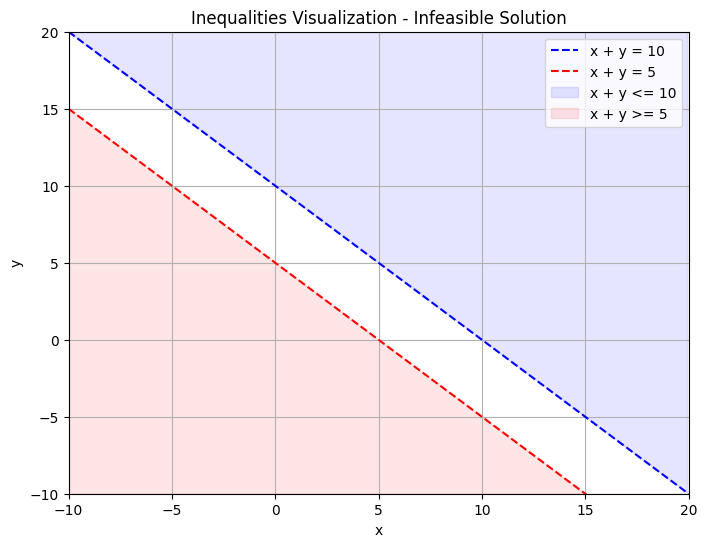

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of x values
x = np.linspace(-10, 20, 400)
y1_upper = 10 - x  # for the line x + y = 10 (upper bound)
y2_lower = 5 - x    # for the line x + y = 5 (lower bound)

# Create the plot
plt.figure(figsize=(8, 6))

# Add the lines representing the boundaries of the inequalities
plt.plot(x, y1_upper, linestyle='--', color='blue', label='x + y = 10')
plt.plot(x, y2_lower, linestyle='--', color='red', label='x + y = 5')

# Shade the region where x + y <= 10
plt.fill_between(x, y1_upper, 20, where=(y1_upper > -10), color='blue', alpha=0.1, label='x + y <= 10')

# Shade the region where x + y >= 5
plt.fill_between(x, y2_lower, -10, where=(y2_lower < 20), color='red', alpha=0.1, label='x + y >= 5')

# Since the inequalities x + y >= 10 and x + y <= 5 are contradictory, there is no feasible region.
# Instead of shading, display a message indicating that the solution is infeasible.
# plt.text(0.5, 0.5, "Infeasible Solution: The inequalities are contradictory.",
#          horizontalalignment='center', verticalalignment='center',
#          fontsize=12, color='red', transform=plt.gca().transAxes)

# Update layout
plt.title('Inequalities Visualization - Infeasible Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-10, 20])
plt.ylim([-10, 20])
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
